В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [75]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [76]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [77]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [217]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000,num_node=[20,1],accuracy=0.00001,lmbd=0.1,beta=0.5,eps=1e-8):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.num_layer=len(num_node)
        self.num_node=num_node
        self.accuracy=accuracy
        self.lmbd=lmbd
        self.beta=beta;
        self.eps=eps;
        self.W=None
        self.b=None
        self.Z=None
        self.A=None
        self.dW=None
        self.db=None
        self.dZ=None
        self.dA=None
        self.SdW=None
        self.Sdb=None
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]        
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    
    def __softmax(self, Z):
        return np.exp(Z) / np.sum(np.exp(Z)) 
    
    def __initialize_parameters(self, n_x):
        
        
        self.W=[]
        self.SdW=[]
        
        self.W.append(list(np.random.randn(self.num_node[0], n_x)/np.sqrt(n_x)))
        self.b=[np.zeros((self.num_node[i], 1)) for i in range(self.num_layer)]
        self.W=self.W+[list((np.random.randn(self.num_node[i],self.num_node[i-1])*
                             np.sqrt(1/(self.num_node[i-1]+self.num_node[i])))) for i in range(1,self.num_layer)]
        
        self.SdW.append(list(np.zeros((self.num_node[0], n_x))))
        self.SdW=self.SdW+[list(np.zeros((self.num_node[i],self.num_node[i-1]))) for i in range(1,self.num_layer)]
        self.Sdb=[np.zeros((self.num_node[i], 1)) for i in range(self.num_layer)]

       
    def __forward_propagation(self, X):

        self.Z=[]
        self.A=[]
        self.Z.append(np.dot(self.W[0], X) + self.b[0])
        self.A.append(self.__sigmoid(self.Z[0]))

        for i in range(1,len(self.W)-1):
            self.Z.append(np.dot(self.W[i], self.A[i-1]) + self.b[i])
            self.A.append(self.__softmax(self.Z[i]))
            
        self.Z.append(np.dot(self.W[-1], self.A[-1]) + self.b[-1])
        self.A.append(self.__sigmoid(self.Z[-1]))
        
        return self.A[-1]
    

        
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        norm = 0
        for i in range(self.num_layer):
            norm += np.linalg.norm(self.W[i], ord = 'fro')
        J = -(1 / m) * np.sum(res)+self.lmbd*norm/(2*m)
        return J
        
    def __backward_propagation(self, X, Y):
        m = X.shape[1]
        n = X.shape[0]
        W, b,Z, A=self.W,self.b,self.Z,self.A

      
        self.dW,self.db,self.dZ,self.dA=[],[],[],[]
        self.dZ.append(A[-1] - Y)
        self.dW.append(1. / m * np.dot(self.dZ[-1], A[-2].T))
        self.db.append(1. / m * np.sum(self.dZ[-1], axis = 1, keepdims = True))
        self.dA.append(np.dot(np.array(W[-1]).T, self.dZ[-1]))       


            

        for i in range(self.num_layer-1):
            self.dZ.append(np.multiply(self.dA[i], np.multiply(A[self.num_layer-2-i], 1 - A[self.num_layer-2-i])))
            if(self.num_layer-3-i>=0):
                self.dW.append( 1. / m * np.dot(self.dZ[i+1], A[self.num_layer-3-i].T))
            else:
                self.dW.append( 1. / m * np.dot(self.dZ[i+1], X.T))
            self.db.append( 1. / m * np.sum(self.dZ[i+1], axis = 1, keepdims = True))
            self.dA.append(np.dot(np.array(W[self.num_layer-2-i]).T, self.dZ[i+1]))
       
        self.dW.reverse()
        self.db.reverse()
        self.dZ.reverse()
        self.dA.reverse()

    
    def __update_parameters(self,m):
        for i in range(self.num_layer):
            self.SdW[i]=self.beta*np.array(self.SdW[i])+(1-self.beta)*np.power(self.dW[i],2)
            self.Sdb[i]=self.beta*np.array(self.Sdb[i])+(1-self.beta)*np.power(self.db[i],2)
#             self.SdW = [np.array(i, dtype=float) for i in self.SdW]
            self.W[i] = self.W[i] - self.learning_rate * self.dW[i]/( np.sqrt(self.SdW[i]) +self.eps)
            self.b[i] = self.b[i] - self.learning_rate * self.db[i]/( np.sqrt(self.Sdb[i]) +self.eps)

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        check = []
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x)
 
        for i in range(self.num_iter):
            A = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            self.__backward_propagation(X, Y)

            self.__update_parameters(m)
        
            check.append(cost)
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 10 == 0:
                costs.append(cost)
                
            if(len(check)>2 and abs(check[i]-check[i-1])<self.accuracy):
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)

Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [218]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [219]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


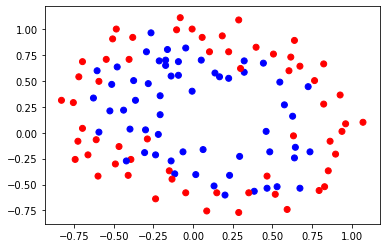

In [220]:
plot_data(X, Y)

In [221]:
cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 4000,num_node=[5,20,],accuracy=0.00000000001)

0-th iteration: 13.970048625390145
1000-th iteration: 9.238014503513142
2000-th iteration: 8.863342295525992
3000-th iteration: 8.798526367576086


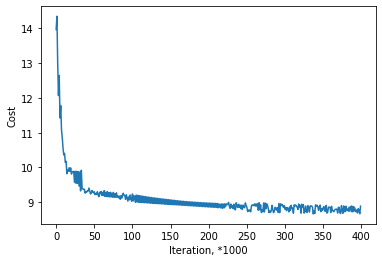

In [222]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [223]:
#print(cls.parameters)

In [224]:
Y_prob = cls.predict_proba(X)
Y_prob

#Я НЕ МОЖУ ЗРОЗУМІТИ ЧОМУ ВІН НЕ БАЧИТЬ SELF.__MEAN

array([[0.54635273, 0.45364727],
       [0.92599008, 0.07400992],
       [0.23893974, 0.76106026],
       [0.150004  , 0.849996  ],
       [0.11709927, 0.88290073],
       [0.91922541, 0.08077459],
       [0.23042617, 0.76957383],
       [0.54048411, 0.45951589],
       [0.92561355, 0.07438645],
       [0.92046006, 0.07953994],
       [0.92598636, 0.07401364],
       [0.78481016, 0.21518984],
       [0.91194995, 0.08805005],
       [0.1501241 , 0.8498759 ],
       [0.92445477, 0.07554523],
       [0.54635282, 0.45364718],
       [0.44719718, 0.55280282],
       [0.92597786, 0.07402214],
       [0.54608027, 0.45391973],
       [0.54634127, 0.45365873],
       [0.92599104, 0.07400896],
       [0.88922874, 0.11077126],
       [0.73788984, 0.26211016],
       [0.14999958, 0.85000042],
       [0.78626867, 0.21373133],
       [0.88464966, 0.11535034],
       [0.27173574, 0.72826426],
       [0.18028307, 0.81971693],
       [0.54628692, 0.45371308],
       [0.54641074, 0.45358926],
       [0.

In [225]:
Y_hat = cls.predict(X)
Y_hat

array([1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0])

In [226]:
accuracy_score(Y, Y_hat)

0.788135593220339

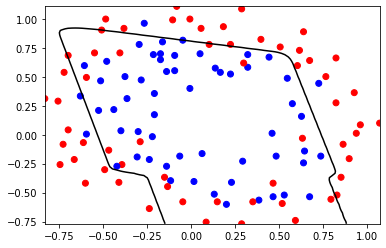

In [227]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [228]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [229]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.01, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

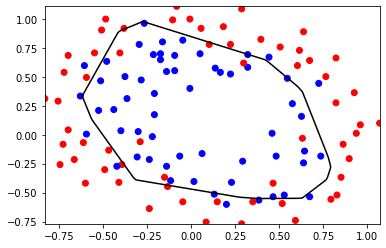

In [125]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [126]:
accuracy_score(Y, clf.predict(X))

0.8559322033898306